# PyTorch CIFAR-10 local training  

## Prerequisites

This notebook shows how to use the SageMaker Python SDK to run your code in a local container before deploying to SageMaker's managed training or hosting environments.  This can speed up iterative testing and debugging while using the same familiar Python SDK interface.  Just change your estimator's `instance_type` to `local` (or `local_gpu` if you're using an ml.p2 or ml.p3 notebook instance).

In order to use this feature, you'll need to install docker-compose (and nvidia-docker if training with a GPU).

**Note: you can only run a single local notebook at one time.**

In [1]:
!/bin/bash ./setup.sh

The user has root access.
nvidia-docker2 already installed. We are good to go!
SageMaker instance route table setup is ok. We are good to go.
SageMaker instance routing for Docker is ok. We are good to go!


## Overview

The **SageMaker Python SDK** helps you deploy your models for training and hosting in optimized, productions ready containers in SageMaker. The SageMaker Python SDK is easy to use, modular, extensible and compatible with TensorFlow, MXNet, PyTorch. This tutorial focuses on how to create a convolutional neural network model to train the [CIFAR-10 dataset](https://www.cs.toronto.edu/~kriz/cifar.html) using **PyTorch in local mode**.

## When should I extend a SageMaker container?

You may not need to create a container to bring your own code to Amazon SageMaker. When you are using a framework such as [TensorFlow](https://github.com/aws/sagemaker-tensorflow-container), [MXNet](https://github.com/aws/sagemaker-mxnet-container), [PyTorch](https://github.com/aws/sagemaker-pytorch-container) or [Chainer](https://github.com/aws/sagemaker-chainer-container) that has direct support in SageMaker, you can simply supply the Python code that implements your algorithm using the SDK entry points for that framework.

Even if there is direct SDK support for your environment or framework, you may want to add additional functionality or configure your container environment differently while utilizing our container to use on SageMaker.

**Some of the reasons to extend a SageMaker deep learning framework container are:**
1. Install additional dependencies. (E.g. I want to install a specific Python library, that the current SageMaker containers don't install.)
2. Configure your environment. (E.g. I want to add an environment variable to my container.)

**Although it is possible to extend any of our framework containers as a parent image, the example this notebook covers is currently only intended to work with our PyTorch (0.4.0+) and Chainer (4.1.0+) containers.**

This walkthrough shows that it is quite straightforward to extend one of our containers to build your own custom container for PyTorch or Chainer.

## Permissions

Running this notebook requires permissions in addition to the normal `SageMakerFullAccess` permissions. This is because it creates new repositories in Amazon ECR. The easiest way to add these permissions is simply to add the managed policy `AmazonEC2ContainerRegistryFullAccess` to the role that you used to start your notebook instance. There's no need to restart your notebook instance when you do this, the new permissions will be available immediately.

## The presentation

This presentation is divided into two parts: _building_ the container and _using_ the container.



## Part 1: Packaging and Uploading your Algorithm for use with Amazon SageMaker

### An overview of Docker

If you're familiar with Docker already, you can skip ahead to the next section.

For many data scientists, Docker containers are a new technology. But they are not difficult and can significantly simplify the deployment of your software packages. 

Docker provides a simple way to package arbitrary code into an _image_ that is totally self-contained. Once you have an image, you can use Docker to run a _container_ based on that image. Running a container is just like running a program on the machine except that the container creates a fully self-contained environment for the program to run. Containers are isolated from each other and from the host environment, so the way your program is set up is the way it runs, no matter where you run it.

Docker is more powerful than environment managers like conda or virtualenv because (a) it is completely language independent and (b) it comprises your whole operating environment, including startup commands, and environment variable.

A Docker container is like a virtual machine, but it is much lighter weight. For example, a program running in a container can start in less than a second and many containers can run simultaneously on the same physical or virtual machine instance.

Docker uses a simple file called a `Dockerfile` to specify how the image is assembled. An example is provided below. You can build your Docker images based on Docker images built by yourself or by others, which can simplify things quite a bit.

Docker has become very popular in programming and devops communities due to its flexibility and its well-defined specification of how code can be run in its containers. It is the underpinning of many services built in the past few years, such as [Amazon ECS].

Amazon SageMaker uses Docker to allow users to train and deploy arbitrary algorithms.

In Amazon SageMaker, Docker containers are invoked in a one way for training and another, slightly different, way for hosting. The following sections outline how to build containers for the SageMaker environment.

Some helpful links:

* [Docker home page](http://www.docker.com)
* [Getting started with Docker](https://docs.docker.com/get-started/)
* [Dockerfile reference](https://docs.docker.com/engine/reference/builder/)
* [`docker run` reference](https://docs.docker.com/engine/reference/run/)

[Amazon ECS]: https://aws.amazon.com/ecs/

### How Amazon SageMaker runs your Docker container

Because you can run the same image in training or hosting, Amazon SageMaker runs your container with the argument `train` or `serve`. How your container processes this argument depends on the container. All SageMaker deep learning framework containers already cover this requirement and will trigger your defined training algorithm and inference code.

* If you specify a program as an `ENTRYPOINT` in the Dockerfile, that program will be run at startup and its first argument will be `train` or `serve`. The program can then look at that argument and decide what to do. The original `ENTRYPOINT` specified within the SageMaker PyTorch is [here](https://github.com/aws/deep-learning-containers/blob/master/pytorch/training/docker/1.5.1/py3/Dockerfile.cpu#L123).

#### Running your container during training

Currently, our SageMaker PyTorch container utilizes [console_scripts](http://python-packaging.readthedocs.io/en/latest/command-line-scripts.html#the-console-scripts-entry-point) to make use of the `train` command issued at training time. The line that gets invoked during `train` is defined within the setup.py file inside [SageMaker Containers](https://github.com/aws/sagemaker-containers/blob/master/setup.py#L48), our common SageMaker deep learning container framework. When this command is run, it will invoke the [trainer class](https://github.com/aws/sagemaker-containers/blob/master/src/sagemaker_containers/cli/train.py) to run, which will finally invoke our [PyTorch container code](https://github.com/aws/sagemaker-pytorch-container/blob/master/src/sagemaker_pytorch_container/training.py) to run your Python file.

A number of files are laid out for your use, under the `/opt/ml` directory:

    /opt/ml
    |-- input
    |   |-- config
    |   |   |-- hyperparameters.json
    |   |   `-- resourceConfig.json
    |   `-- data
    |       `-- <channel_name>
    |           `-- <input data>
    |-- model
    |   `-- <model files>
    `-- output
        `-- failure

##### The input

* `/opt/ml/input/config` contains information to control how your program runs. `hyperparameters.json` is a JSON-formatted dictionary of hyperparameter names to values. These values are always strings, so you may need to convert them. `resourceConfig.json` is a JSON-formatted file that describes the network layout used for distributed training.
* `/opt/ml/input/data/<channel_name>/` (for File mode) contains the input data for that channel. The channels are created based on the call to CreateTrainingJob but it's generally important that channels match algorithm expectations. The files for each channel are copied from S3 to this directory, preserving the tree structure indicated by the S3 key structure. 
* `/opt/ml/input/data/<channel_name>_<epoch_number>` (for Pipe mode) is the pipe for a given epoch. Epochs start at zero and go up by one each time you read them. There is no limit to the number of epochs that you can run, but you must close each pipe before reading the next epoch.

##### The output

* `/opt/ml/model/` is the directory where you write the model that your algorithm generates. Your model can be in any format that you want. It can be a single file or a whole directory tree. SageMaker packages any files in this directory into a compressed tar archive file. This file is made available at the S3 location returned in the `DescribeTrainingJob` result.
* `/opt/ml/output` is a directory where the algorithm can write a file `failure` that describes why the job failed. The contents of this file are returned in the `FailureReason` field of the `DescribeTrainingJob` result. For jobs that succeed, there is no reason to write this file as it is ignored.

#### Running your container during hosting

Hosting has a very different model than training because hosting is reponding to inference requests that come in via HTTP. Currently, the SageMaker PyTorch containers [uses](https://github.com/aws/sagemaker-pytorch-container/blob/master/src/sagemaker_pytorch_container/serving.py#L103) our [recommended Python serving stack](https://github.com/aws/sagemaker-containers/blob/master/src/sagemaker_containers/_server.py#L44) to provide robust and scalable serving of inference requests:

![Request serving stack](stack.png)

Amazon SageMaker uses two URLs in the container:

* `/ping` receives `GET` requests from the infrastructure. Your program returns 200 if the container is up and accepting requests.
* `/invocations` is the endpoint that receives client inference `POST` requests. The format of the request and the response is up to the algorithm. If the client supplied `ContentType` and `Accept` headers, these are passed in as well. 

The container has the model files in the same place that they were written to during training:

    /opt/ml
    `-- model
        `-- <model files>


### The parts of the sample container

The `container` directory has all the components you need to extend the SageMaker PyTorch container to use as an sample algorithm:

    .
    |-- Dockerfile
    |-- build_and_push.sh
    `-- cifar10
        `-- cifar10.py

Let's discuss each of these in turn:

* __`Dockerfile`__ describes how to build your Docker container image. More details are provided below.
* __`build_and_push.sh`__ is a script that uses the Dockerfile to build your container images and then pushes it to ECR. We invoke the commands directly later in this notebook, but you can just copy and run the script for your own algorithms.
* __`cifar10`__ is the directory which contains our user code to be invoked.

In this simple application, we install only one file in the container. You may only need that many, but if you have many supporting routines, you may wish to install more.

The files that we put in the container are:

* __`cifar10.py`__ is the program that implements our training algorithm and handles loading our model for inferences.

### The Dockerfile

The Dockerfile describes the image that we want to build. You can think of it as describing the complete operating system installation of the system that you want to run. A Docker container running is quite a bit lighter than a full operating system, however, because it takes advantage of Linux on the host machine for the basic operations. 

We start from the SageMaker PyTorch image as the base. The base image is an ECR image, so it will have the following pattern.
* {account}.dkr.ecr.{region}.amazonaws.com/sagemaker-{framework}:{framework_version}-{processor_type}-{python_version}

Here is an explanation of each field.
1. account - AWS account ID the ECR image belongs to. Our public deep learning framework images are all under the 520713654638 account.
2. region - The region the ECR image belongs to. [Available regions](https://aws.amazon.com/about-aws/global-infrastructure/regional-product-services/).
3. framework - The deep learning framework.
4. framework_version - The version of the deep learning framework.
5. processor_type - CPU or GPU.
6. python_version - The supported version of Python.

So the SageMaker PyTorch inference ECR image would be:
763104351884.dkr.ecr.$REGION.amazonaws.com/pytorch-inference:1.11.0-gpu-py38-cu113-ubuntu20.04-sagemaker
    
Information on supported frameworks and versions can be found in this [README](https://github.com/aws/sagemaker-python-sdk).

Next, we add the code that implements our specific algorithm to the container and set up the right environment for it to run under.


Finally, we need to specify two environment variables.
1. SAGEMAKER_SUBMIT_DIRECTORY - the directory within the container containing our Python script for training and inference.
2. SAGEMAKER_PROGRAM - the Python script that should be invoked for training and inference.

Let's look at the Dockerfile for this example.

### Building and registering the container

The following shell code shows how to build the container image using `docker build` and push the container image to ECR using `docker push`. This code is also available as the shell script `container/build-and-push.sh`, which you can run as `build-and-push.sh pytorch-extending-our-containers-cifar10-example` to build the image `pytorch-extending-our-containers-cifar10-example`. 

This code looks for an ECR repository in the account you're using and the current default region (if you're using a SageMaker notebook instance, this is the region where the notebook instance was created). If the repository doesn't exist, the script will create it. In addition, since we are using the SageMaker PyTorch image as the base, we will need to retrieve ECR credentials to pull this public image.

In [ ]:
%%sh

# The name of our algorithm
algorithm_name=pytorch-extending-our-containers-example

cd container

account=$(aws sts get-caller-identity --query Account --output text)

# Get the region defined in the current configuration (default to us-west-2 if none defined)
region=$(aws configure get region)
region=${region:-us-west-2}

fullname="${account}.dkr.ecr.${region}.amazonaws.com/${algorithm_name}:latest"

# If the repository doesn't exist in ECR, create it.

aws ecr describe-repositories --repository-names "${algorithm_name}" > /dev/null 2>&1

if [ $? -ne 0 ]
then
    aws ecr create-repository --repository-name "${algorithm_name}" > /dev/null
fi

# Get the login command from ECR and execute it directly
$(aws ecr get-login --region ${region} --no-include-email)

# Get the login command from ECR in order to pull down the SageMaker PyTorch image
$(aws ecr get-login --registry-ids 763104351884 --region ${region} --no-include-email)

# Build the docker image locally with the image name and then push it to ECR
# with the full name.

docker build  -t ${algorithm_name} . --build-arg REGION=${region}
docker tag ${algorithm_name} ${fullname}

docker push ${fullname}

## Part 2: Training your Algorithm in Amazon SageMaker with prebuilt pytorch container
We firstly train a pytorch model based on the prebuilt container image

### Set up the environment

This notebook was created and tested on a single ml.p2.xlarge notebook instance.

Let's start by specifying:

- The S3 bucket and prefix that you want to use for training and model data. This should be within the same region as the Notebook Instance, training, and hosting.
- The IAM role arn used to give training and hosting access to your data. See the documentation for how to create these. Note, if more than one role is required for notebook instances, training, and/or hosting, please replace the sagemaker.get_execution_role() with appropriate full IAM role arn string(s).

In [2]:
import sagemaker

sagemaker_session = sagemaker.Session()

bucket = sagemaker_session.default_bucket()
prefix = "sagemaker/DEMO-pytorch-cnn-cifar10"

role = sagemaker.get_execution_role()

In [3]:
import os
import subprocess

instance_type = "local"

try:
    if subprocess.call("nvidia-smi") == 0:
        ## Set type to GPU if one is present
        instance_type = "local_gpu"
except:
    pass

print("Instance type = " + instance_type)

Sat Jun 18 09:47:56 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            On   | 00000000:00:1E.0 Off |                    0 |
| N/A   34C    P8    15W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Download the CIFAR-10 dataset

In [4]:
from utils_cifar import get_train_data_loader, get_test_data_loader, imshow, classes

trainloader = get_train_data_loader()
testloader = get_test_data_loader()

Matplotlib is building the font cache; this may take a moment.


  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


### Data Preview

     bird      frog       car       dog


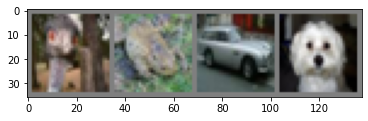

In [5]:
import numpy as np
import torchvision, torch

# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))

# print labels
print(" ".join("%9s" % classes[labels[j]] for j in range(4)))

### Upload the data
We use the ```sagemaker.Session.upload_data``` function to upload our datasets to an S3 location. The return value inputs identifies the location -- we will use this later when we start the training job.

In [6]:
inputs = sagemaker_session.upload_data(path="data", bucket=bucket, key_prefix="data/cifar10")

# Construct a script for training 
Here is the full code for the network model:

In [7]:
!pygmentize source/cifar10.py

import argparse
import logging
import os

import torch
import torch.distributed as dist
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.parallel
import torch.optim
import torch.utils.data
import torch.utils.data.distributed
import torchvision
import torchvision.models
import torchvision.transforms as transforms

try:
    from sagemaker_inference import environment
except:
    from sagemaker_training import environment

logger = logging.getLogger(__name__)
logger.setLevel(logging.DEBUG)

classes = ("plane", "car", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck")


# https://github.com/pytorch/tutorials/blob/master/beginner_source/blitz/cifar10_tutorial.py#L118
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        s

## Script Functions

SageMaker invokes the main function defined within your training script for training. When deploying your trained model to an endpoint, the model_fn() is called to determine how to load your trained model. The model_fn() along with a few other functions list below are called to enable predictions on SageMaker.

### [Predicting Functions](https://github.com/aws/sagemaker-pytorch-containers/blob/master/src/sagemaker_pytorch_container/serving.py)
* model_fn(model_dir) - loads your model.
* input_fn(serialized_input_data, content_type) - deserializes predictions to predict_fn.
* output_fn(prediction_output, accept) - serializes predictions from predict_fn.
* predict_fn(input_data, model) - calls a model on data deserialized in input_fn.

The model_fn() is the only function that doesn't have a default implementation and is required by the user for using PyTorch on SageMaker. 

## Create a training job using the sagemaker.PyTorch estimator

The `PyTorch` class allows us to run our training function on SageMaker. We need to configure it with our training script, an IAM role, the number of training instances, and the training instance type. For local training with GPU, we could set this to "local_gpu".  In this case, `instance_type` was set above based on your whether you're running a GPU instance.

After we've constructed our `PyTorch` object, we fit it using the data we uploaded to S3. Even though we're in local mode, using S3 as our data source makes sense because it maintains consistency with how SageMaker's distributed, managed training ingests data.


In [8]:
from sagemaker.pytorch import PyTorch

cifar10_estimator = PyTorch(
    image_uri='763104351884.dkr.ecr.us-east-1.amazonaws.com/pytorch-training:1.11.0-gpu-py38-cu113-ubuntu20.04-sagemaker',
    entry_point="source/cifar10.py",
    role=role,
#     framework_version="1.7.1",
    py_version="py3",
    instance_count=1,
    instance_type=instance_type,
#     instance_type='ml.g4dn.xlarge',
#     wait=False
)

cifar10_estimator.fit(inputs)

WARNING! Using --password via the CLI is insecure. Use --password-stdin.
WARNING! Your password will be stored unencrypted in /home/ec2-user/.docker/config.json.
Configure a credential helper to remove this warning. See
https://docs.docker.com/engine/reference/commandline/login/#credentials-store



Creating rctzc4rcli-algo-1-oh7dn ... 
Creating rctzc4rcli-algo-1-oh7dn ... done
Attaching to rctzc4rcli-algo-1-oh7dn
rctzc4rcli-algo-1-oh7dn | INFO:sagemaker-training-toolkit:No exception classes found in smdistributed.dataparallel
rctzc4rcli-algo-1-oh7dn | INFO:sagemaker-training-toolkit:Imported framework sagemaker_pytorch_container.training
rctzc4rcli-algo-1-oh7dn | INFO:sagemaker_pytorch_container.training:Block until all host DNS lookups succeed.
rctzc4rcli-algo-1-oh7dn | INFO:sagemaker_pytorch_container.training:Invoking user training script.
rctzc4rcli-algo-1-oh7dn | INFO:sagemaker-training-toolkit:Invoking user script
rctzc4rcli-algo-1-oh7dn | 
rctzc4rcli-algo-1-oh7dn | Training Env:
rctzc4rcli-algo-1-oh7dn | 
rctzc4rcli-algo-1-oh7dn | {
rctzc4rcli-algo-1-oh7dn |     "additional_framework_parameters": {},
rctzc4rcli-algo-1-oh7dn |     "channel_input_dirs": {
rctzc4rcli-algo-1-oh7dn |         "training": "/opt/ml/input/data/training"
rctzc4rcli-algo-1-oh7dn |     },
rctzc4rcli-a

## Part 3: Hosting the pretrained model using extended pytorch container image

## Create a SageMaker endpoint using BYOM model
In this section, we will demonstrate how to create a SageMaker real-time endpoint using your own pretrained model.

More information about the different functions in the inference.py file can be found here. https://sagemaker-examples.readthedocs.io/en/latest/frameworks/pytorch/get_started_mnist_deploy.html#Entry-Point-for-the-Inference-Image

In [12]:
model_url = cifar10_estimator.model_data
print(model_url)

s3://sagemaker-us-east-1-631450739534/pytorch-training-2022-06-18-09-50-50-352/model.tar.gz


In [53]:
from sagemaker.pytorch import PyTorchModel
from sagemaker.serializers import JSONSerializer
from sagemaker.deserializers import JSONDeserializer

pytorch_endpoint_name = "pytorch-endpoint-realtime"

In [196]:
model = PyTorchModel(
    entry_point="inference.py",
    source_dir="code",
    role=role,
    model_data=model_url,
    framework_version="1.11.0",
    py_version="py3",
    image_uri='pytorch-extending-our-containers-example:latest',
#     image_uri='631450739534.dkr.ecr.us-east-1.amazonaws.com/pytorch-extending-our-containers-example:latest'
)

In [203]:
predictor = model.deploy(
    initial_instance_count=1,
    instance_type=instance_type,
#     instance_type='ml.g4dn.xlarge',
    serializer=JSONSerializer(),
    deserializer=JSONDeserializer(),
)

Attaching to anftpb2son-algo-1-boz5w
anftpb2son-algo-1-boz5w | ['torchserve', '--start', '--model-store', '/.sagemaker/ts/models', '--ts-config', '/etc/sagemaker-ts.properties', '--log-config', '/opt/conda/lib/python3.8/site-packages/sagemaker_pytorch_serving_container/etc/log4j2.xml', '--models', 'model=/opt/ml/model']
anftpb2son-algo-1-boz5w | WARNING: sun.reflect.Reflection.getCallerClass is not supported. This will impact performance.
anftpb2son-algo-1-boz5w | 2022-06-18T12:37:19,905 [INFO ] main org.pytorch.serve.servingsdk.impl.PluginsManager - Initializing plugins manager...
anftpb2son-algo-1-boz5w | 2022-06-18T12:37:20,000 [INFO ] main org.pytorch.serve.ModelServer - 
anftpb2son-algo-1-boz5w | Torchserve version: 0.6.0
anftpb2son-algo-1-boz5w | TS Home: /opt/conda/lib/python3.8/site-packages
anftpb2son-algo-1-boz5w | Current directory: /
anftpb2son-algo-1-boz5w | Temp directory: /home/model-server/tmp
anftpb2son-algo-1-boz5w | Number of GPUs: 1
anftpb2son-algo-1-boz5w | Number 

## Making predictions using Python SDK

To make predictions, we will use a few images, from the test loader, converted into a json format to send as an inference request.

The reponse will be tensors containing the probabilities of each image belonging to one of the 10 classes. Based on the highest probability we will map that index to the corresponding class in our output. The classes can be referenced from the [CIFAR-10 website](https://www.cs.toronto.edu/~kriz/cifar.html). Since we didn't train the model for that long, we aren't expecting very accurate results.

In [87]:
dataiter = iter(testloader)

In [ ]:
import torchvision, torch
import numpy as np

from sagemaker.predictor import json_serializer, json_deserializer

# get some test images

images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print("GroundTruth: ", " ".join("%4s" % classes[labels[j]] for j in range(4)))


outputs = predictor.predict(images.numpy())

_, predicted = torch.max(torch.from_numpy(np.array(outputs)), 1)

print("Predicted: ", " ".join("%4s" % classes[predicted[j]] for j in range(4)))

In [120]:
file_name = 'example_file.json'
with open(file_name, 'r') as file:
    tmp = json.load(file)
tmp

{'data_source': 's3://sagemaker-us-east-1-631450739534/sagemaker/DEMO-pytorch-cnn-cifar10/data/example_file.json'}

In [204]:
outputs = predictor.predict(tmp)

_, predicted = torch.max(torch.from_numpy(np.array(outputs)), 1)

print("Predicted: ", " ".join("%4s" % classes[predicted[j]] for j in range(4)))

anftpb2son-algo-1-boz5w | 2022-06-18T12:37:31,534 [INFO ] W-9000-model_1.0 org.pytorch.serve.wlm.WorkerThread - Flushing req. to backend at: 1655555851534
anftpb2son-algo-1-boz5w | 2022-06-18T12:37:31,536 [INFO ] W-9000-model_1.0-stdout MODEL_LOG - Backend received inference at: 1655555851
anftpb2son-algo-1-boz5w | 2022-06-18T12:37:31,536 [INFO ] W-9000-model_1.0-stdout MODEL_LOG - request type: application/json
anftpb2son-algo-1-boz5w | 2022-06-18T12:37:31,593 [INFO ] W-9000-model_1.0-stdout MODEL_LOG - {'data_source': 's3://sagemaker-us-east-1-631450739534/sagemaker/DEMO-pytorch-cnn-cifar10/data/example_file.json'}
anftpb2son-algo-1-boz5w | 2022-06-18T12:37:31,780 [INFO ] W-9000-model_1.0-stdout MODEL_LOG - Downloading https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz to ./data/cifar-10-python.tar.gz
anftpb2son-algo-1-boz5w | 2022-06-18T12:37:31,780 [WARN ] W-9000-model_1.0-stderr MODEL_LOG - 
anftpb2son-algo-1-boz5w | 2022-06-18T12:37:31,881 [WARN ] W-9000-model_1.0-stderr MOD

# Clean-up

Deleting the local endpoint when you're finished is important, since you can only run one local endpoint at a time.

In [205]:
predictor.delete_endpoint()

Gracefully stopping... (press Ctrl+C again to force)


## Appendix 

## Prediction on the local machine

In [68]:
import os

import torch
import torch.distributed as dist
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.parallel
import torch.optim
import torch.utils.data
import torch.utils.data.distributed
import torchvision
import torchvision.models
import torchvision.transforms as transforms

In [69]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [70]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = Net()
model_dir = 'model'
if torch.cuda.device_count() > 1:
    logger.info("Gpu count: {}".format(torch.cuda.device_count()))
    model = nn.DataParallel(model)

with open(os.path.join(model_dir, "model.pth"), "rb") as f:
    model.load_state_dict(torch.load(f))
model.to(device)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [71]:
tensor = torch.FloatTensor(torch.from_numpy(images.numpy()))
tensor.to(device)

tensor([[[[-0.6235, -0.4902, -0.3412,  ..., -0.5216, -0.6157, -0.6471],
          [-0.8902, -0.8745, -0.8510,  ..., -0.7647, -0.8431, -0.8196],
          [-0.7647, -0.7176, -0.7490,  ..., -0.7725, -0.8275, -0.8196],
          ...,
          [ 0.0353,  0.0275,  0.0275,  ...,  0.2471,  0.1765,  0.1529],
          [ 0.0118,  0.0275,  0.0118,  ...,  0.2627,  0.3020,  0.3255],
          [-0.0039,  0.0588,  0.0667,  ...,  0.1294,  0.0980,  0.1373]],

         [[-0.6157, -0.4667, -0.3020,  ..., -0.5059, -0.6078, -0.6471],
          [-0.8980, -0.8824, -0.8510,  ..., -0.7490, -0.8275, -0.8196],
          [-0.6941, -0.6941, -0.7412,  ..., -0.7569, -0.8118, -0.8118],
          ...,
          [ 0.1765,  0.1686,  0.1686,  ...,  0.3098,  0.2392,  0.1922],
          [ 0.1529,  0.1608,  0.1451,  ...,  0.3098,  0.3569,  0.3490],
          [ 0.1451,  0.1922,  0.1843,  ...,  0.1765,  0.1451,  0.1686]],

         [[-0.6235, -0.4745, -0.3176,  ..., -0.5373, -0.6392, -0.6706],
          [-0.8980, -0.8980, -

In [72]:
input_data = tensor.to(device)
with torch.no_grad():
    with torch.jit.optimized_execution(True):
        output = model.forward(input_data)

In [74]:
output.detach().cpu().numpy().tolist()

[[0.2368011772632599,
  -1.4373328685760498,
  0.6225817799568176,
  0.18415576219558716,
  1.4022583961486816,
  0.5464974641799927,
  -2.4792137145996094,
  4.582212924957275,
  -2.5382938385009766,
  0.8987858891487122],
 [6.445296764373779,
  -2.9003100395202637,
  7.4543633460998535,
  0.5750448703765869,
  0.22989746928215027,
  -0.07983846962451935,
  -2.001847982406616,
  -2.268155097961426,
  -2.2423126697540283,
  -3.8881969451904297],
 [4.2440643310546875,
  -1.8359901905059814,
  2.927513599395752,
  -0.7629748582839966,
  1.3571178913116455,
  -1.2222861051559448,
  -0.8545094728469849,
  -2.7550811767578125,
  1.9177950620651245,
  -1.558739423751831],
 [-1.041499376296997,
  5.539721488952637,
  -2.36578631401062,
  -0.8541748523712158,
  -3.0113518238067627,
  -1.201171875,
  1.0714792013168335,
  -1.9689130783081055,
  -3.3783254623413086,
  8.537617683410645]]

## prepare a sample json file (optional)

In [112]:
import json
dictionary ={
    "data_source" : f"s3://{bucket}/sagemaker/DEMO-pytorch-cnn-cifar10/data/example_file.json",
}
  
# Serializing json 
json_object = json.dumps(dictionary, indent = 4)

file_name = "example_file.json"
# Writing to sample.json
with open(file_name, "w") as outfile:
    outfile.write(json_object)

In [113]:
import boto3
client = boto3.client("s3")

In [114]:
client.upload_file(file_name, bucket, os.path.join(prefix, "data", file_name))